<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import re
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
# PATH_TO_DATA = r'C:\Users\Дмитрий Мошкин\Documents\GitHub\moshkin\MFTI_Yandex_DA_specialisation\6 course\capstone_user_identification'
PATH_TO_DATA = r'C:\Users\MI\Documents\GitHub\moshkin\MFTI_Yandex_DA_specialisation\6 course\capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
with open(os.path.join(PATH_TO_DATA, '10users\\user0031.csv')) as f:
    frame = pd.read_csv(f)

In [4]:
frame.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


In [5]:
def table_trasformer(data, filename, dic, additional_feature_number, session_length=10, window_size=10):
    '''transform single table'''
    
#   Pull websites in original order and replace names with indices from dic:
    
    sites = [dic[i][0] for i in data.site.values]
    if len(data) < session_length:
        unique_sites_feature = len(np.unique(sites))
        sites = sites + [0]*abs(len(sites) - session_length)

    
    i = 0
    while True:
        
#   Create session-row:
        
        row = sites[i:(i + session_length)]
        if 0 not in row:
            unique_sites_feature = len(np.unique(row))
        row = row + [0]*(additional_feature_number) # [0] in row for each additional feature
        if sum(row) == 0:
            break
        if i == 0:
            frame = np.array([row])
        else:
            try:
                frame = np.append(frame, [row], axis=0)
            except ValueError:
                delta = abs(len(frame[0]) - len(row))
                frame = np.append(frame, [row + [0]*delta], axis=0)

#   Add features:
        
        
        time_stamps = data.timestamp[i:(i + session_length)].apply(pd.to_datetime)    
        time_diffs = time_stamps.diff()
        ind = 0    
        for gap in time_diffs[1:]:
            frame[-1][session_length+ind] = gap.seconds
            ind += 1
            
            
        session_timespan_feature = (time_stamps.max() - time_stamps.min()).seconds
        day_of_week_feature = time_stamps.min().dayofweek
        start_hour_feature = time_stamps.min().hour
        userindex = re.findall(r'(\d*).csv', filename)[0]
        frame[-1][-5] = session_timespan_feature
        frame[-1][-4] = unique_sites_feature
        frame[-1][-3] = start_hour_feature
        frame[-1][-2] = day_of_week_feature
        frame[-1][-1] = userindex
        
        i += window_size

    return frame

In [6]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    '''
    takes:
        path_to_csv_files - path to CSV files
        site_freq_path - path to a pickle file containing frequent dict
        feature_names - dict with names of features
        session_length - session legnth, int
        window_size - window size, int
        
    returns:
        matrix with session_length rows and len(feature_names) columns
     '''
    
    X = None
    additional_feature_number = len(feature_names) - session_length
# Pull filenames to the list:

    os.chdir(path_to_csv_files)
    filenames = sorted(os.listdir())

# Load dictionary with websites' indices:
    
    with open(site_freq_path, 'rb') as f:
        dic = pickle.load(f)
        
# Retrive website name from a file, transform and merge into overall array:
        
    for filename in tqdm_notebook(filenames):
        if '.csv' in filename:
            file = pd.read_csv(os.path.join(path_to_csv_files, filename))
            csvresult = table_trasformer(file, filename, dic, additional_feature_number, session_length, 
                              window_size)
            try:
                X = np.append(X, csvresult, axis=0)
            except ValueError:
                X = csvresult
    return pd.DataFrame(X, columns=feature_names)
#     return X

**Проверим функцию на игрушечном примере.**

In [7]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,9,2,1,7,5,8,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [8]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,9,2,1,7,5,8,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
#%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

In [9]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,576,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,421,193,677,254,133,31,393,3403,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,421,333,899,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3570,473,55,55,55,55,946,200,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,343,55,5,3399,258,212,3498,2095,674,2095,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [276]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)


Wall time: 3min 18s


In [416]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,1,4,2,1,4,1,2,1290,322,1,1,1,4,0,1,0,49,0,57,5,8,4,6
1,2,23,1505,1290,322,322,113,73,49,49,0,0,26,1,10,73,0,1504,4,1618,8,8,4,6
2,322,205,1,1,1,1,73,322,2,1,1,10,1,5,16,56,1917,0,4,2010,5,8,4,6
3,1,1,7000,7000,5494,7000,7000,1,35,1,1,0,1,0,118,420,1460,6,0,2006,4,9,4,6
4,1,1,76,1,58,50,58,50,83,76,4,3,0,1,0,1,0,1,0,10,5,9,4,6


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [417]:
new_features_10users = train_data_10users.iloc[:, 19:23]
new_features_150users = train_data_150users.iloc[:, 19:23]

In [418]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

In [419]:
new_features_10users.columns

Index(['session_timespan', '#unique_sites', 'start_hour', 'day_of_week'], dtype='object')

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [420]:
new_features_10users.session_timespan.median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [421]:
new_features_10users.day_of_week.median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [422]:
new_features_10users.start_hour.median()

14.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [423]:
new_features_10users[r'#unique_sites'].median()

6.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [10]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [11]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

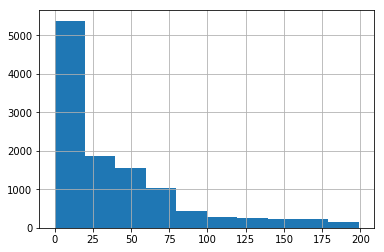

In [12]:
train_data_10users['session_timespan'][train_data_10users['session_timespan']<200].hist();

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

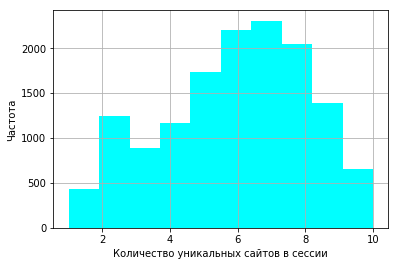

In [15]:
fig = plt.figure()
plot = train_data_10users['#unique_sites'].hist(color = "aqua")
plot.set_xlabel('Количество уникальных сайтов в сессии')
plot.set_ylabel('Частота');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

<Figure size 432x288 with 0 Axes>

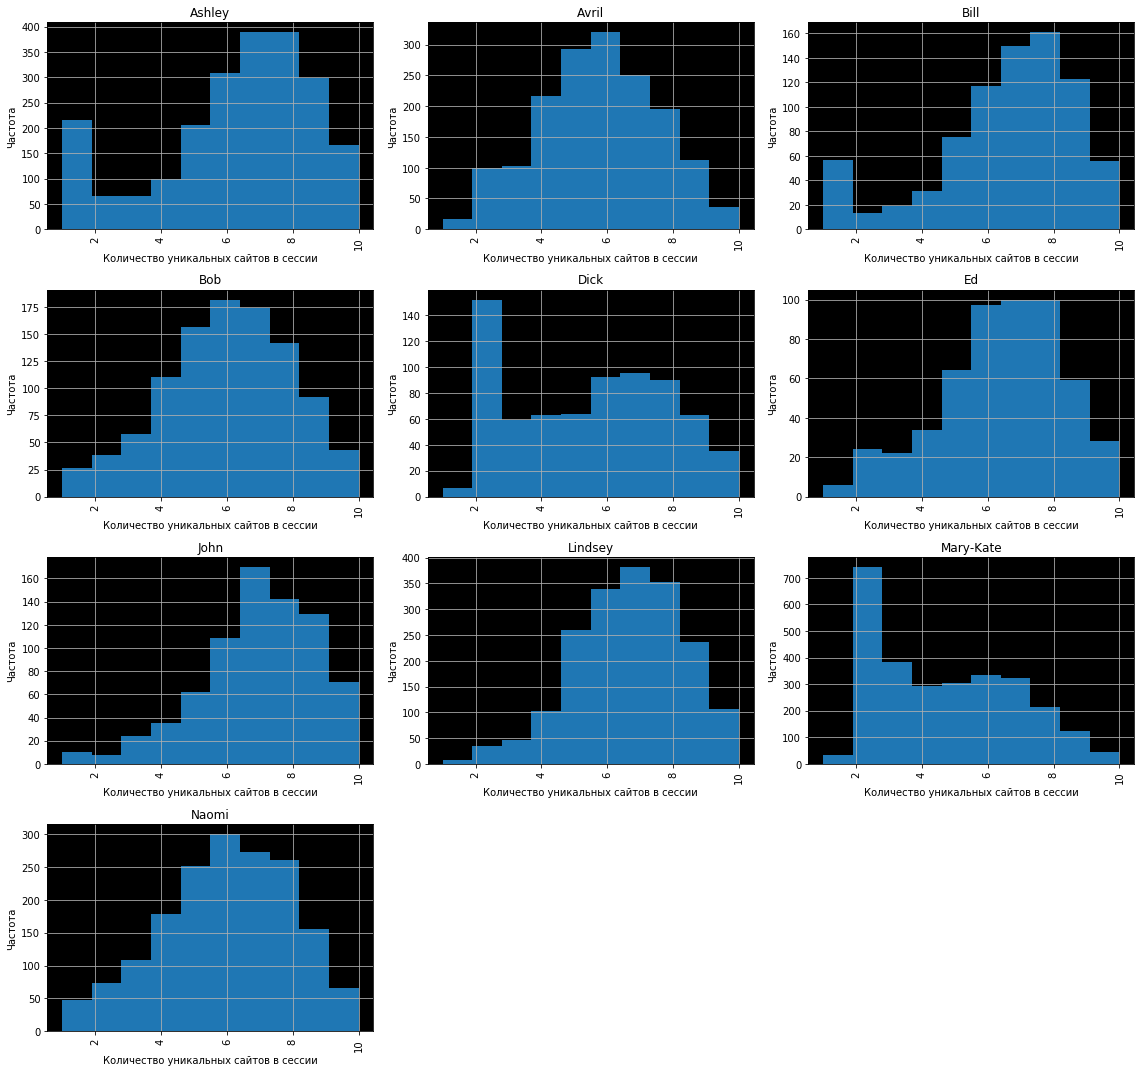

In [19]:
plt.figure()
plot = train_data_10users.hist(column='#unique_sites', by=train_data_10users['target'], figsize=(16, 15));
for ax in plot.flatten():
    ax.set_xlabel('Количество уникальных сайтов в сессии')
    ax.set_ylabel("Частота")
    ax.grid()
    ax.set_facecolor('k')
plt.tight_layout()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

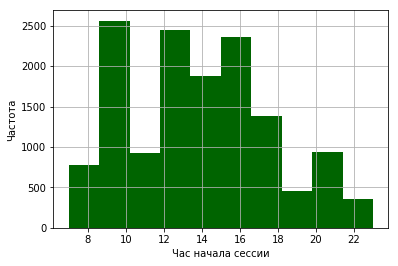

In [165]:
# ну и отстойный цвет :/

plot = train_data_10users['start_hour'].hist(color='darkgreen')
plot.set_xlabel('Час начала сессии')
plot.set_ylabel('Частота');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

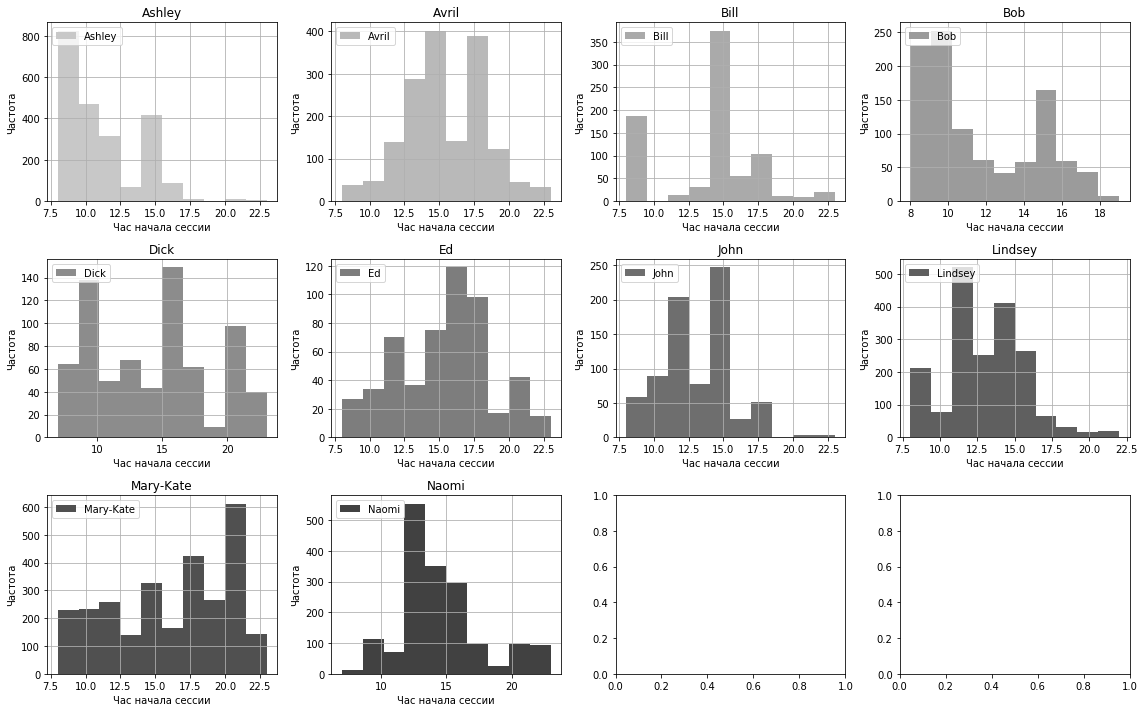

In [169]:
cm = plt.cm.get_cmap('binary')
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, user_name in enumerate(np.unique(train_data_10users.target.values)):
    plot = train_data_10users['start_hour'][train_data_10users.target == user_name].hist(
        ax=axes[idx // 4, idx % 4], color=cm(40+15*(idx+1)))
    plot.set_xlabel('Час начала сессии')
    plot.set_ylabel('Частота')
    plot.set_title(user_name)
    plot.legend((user_name,), loc="upper left")
plt.tight_layout()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

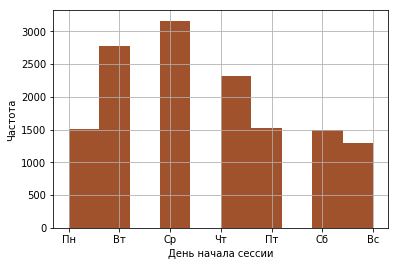

In [125]:
x = [0, 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plot = train_data_10users['day_of_week'].hist(color='sienna')
plot.set_xlabel('День начала сессии')
plot.set_ylabel('Частота');
plot.set_xticklabels(x);

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

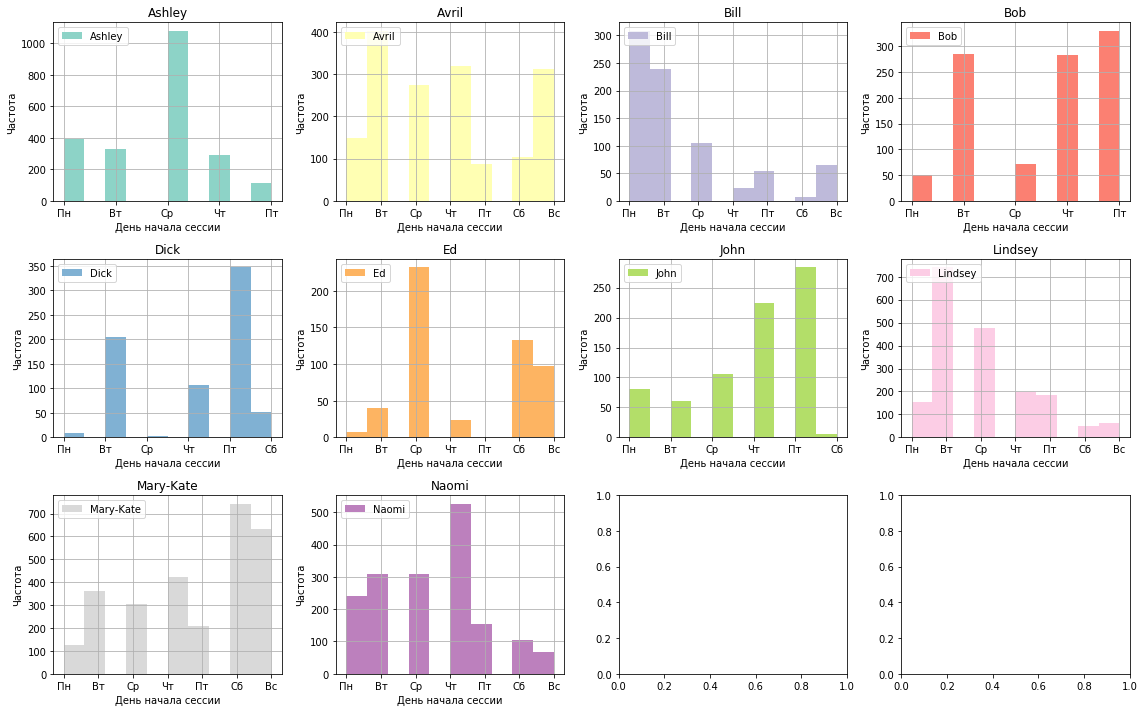

In [124]:
x = [0, 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
cm = plt.cm.get_cmap('Set3')
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for idx, user_name in enumerate(np.unique(train_data_10users.target.values)):
    plot = train_data_10users['day_of_week'][train_data_10users.target == user_name].hist(
        ax=axes[idx // 4, idx % 4], color=cm(idx))
    plot.set_xlabel('День начала сессии')
    plot.set_ylabel('Частота')
    plot.set_title(user_name)
    plot.legend((user_name,), loc="upper left")
    plot.set_xticklabels(x);
plt.tight_layout()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Ashley
В сессии чаще всего 7 сайтов. Группировка вокруг 7ми с крупным выбросом на единице.
Намного больше сессий приходится на ранее утро.
Среда - любимый день. Суббота и воскресенье - нерабочие дни.
В сессии чаще всего 6 сайтов. Группировка вокруг 6ти.

Avril
Пики рабочего процесса в интернете приходятся на 15:00 и 17:00. Напомиает гауссиану с провалами.
Вторник - пик частоты активности. Среда, четверг, воскресенье - дни более частой активности.
Bill
Большинство сессий приходятся на 15:00, в два раза меньше, но тоже значительное количество на 8:30.
Понедельник, вторник - дни наиболее вероятной активности.

Bob
В сессии чаще всего 6 сайтов. Группировка вокруг 6ти со скосом в большую сторону.
Больше сессий с утра, да и вообще много сессий.
Вторник, чертверг, пятница- наиболее часто активные дни. Суббота и воскресенье - нерабочие дни.

Dick
Более-менее равномерное распределение сессий с тремя пиками
Понедельник, среда - редкая активность. Пятница - пик частоты активности. Далее частоты активности по убыванию: вторик, четверг, суббота. Воскресение - нерабочий день.

Ed
В сессии чаще всего 7 или 8 сайтов, так же очень часто 6. Далее по нисходящей.
Пик начала сессий на середине дня, сессий сравнительно немного. Напомиает гауссиану с крупными выбросами.
Среда, суббота, воскресение - пики частоты активности. Топ в среду. 

John
В сессии чаще всего 7 сайтов. Группировка вокруг 7ти со скосом в большую сторону.
Основные сессии приходятся на рабочие часы с пиками на 11 и 15 часов.
Частая активность во все рабочие дни со скосом в сторону пятницы. Суббота редкая активность. Воскресение - нерабочий день.


Lindsey
В сессии чаще всего 7 сайтов. Группировка вокруг 7ти со скосом в большую сторону.
Сессии сдвинуты в сторону первой половины дня.
Вторник - пик частоты активности. Далее по нисходящей до понедельника.

Mary-Kate
В сессии чаще всего 3 сайта. Минимальное количество с одним уникальным сайтом. В остальном распределением более-менее равномерное.
В целом больше сессий в сравнении с другими, при чем пик на вечернее время.
Суббота, воскресенье - концентраторы активности.

Naomi
В сессии чаще всего 6 сайтов. Группировка вокруг 6ти со скосом в большую сторону.
Пик сессий на 11 утра, 11-18 наиболее активное время.
Четверг - концентратор активности, далее вторник и среда.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [21]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    dic = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [164]:
# dic has been initially sorted by descending

top10_freqs = [i[1][1] for i in dic.items()][0:10]
top10_sites = [i for i in dic][0:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

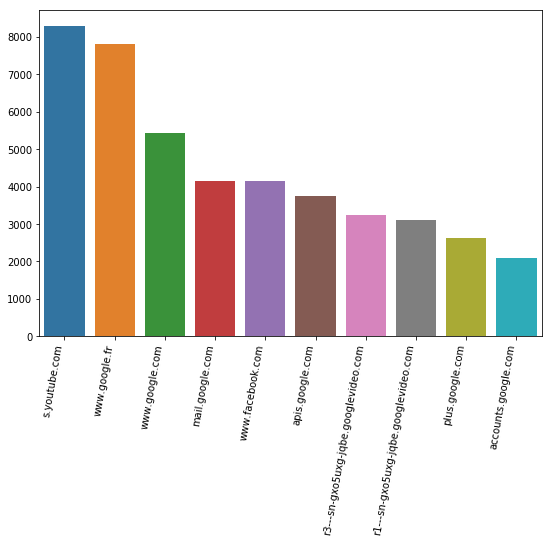

In [163]:
plt.figure(figsize=(9,6))
plot = sns.barplot(top10_sites, top10_freqs)
plt.xticks(rotation='80', ha='right');

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 